# 🤖 Logistic Regression Baseline

This notebook implements a simple and interpretable **Logistic Regression** model as a baseline for satire detection. It uses TF-IDF vectorization on cleaned French headlines and evaluates classification performance.

---

## 📚 Imports & Setup

In [15]:
import os

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from french_stop_words import FRENCH_STOP_WORDS
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

---

## 🧾 Load Cleaned Dataset

In [6]:
df: DataFrame = pd.read_csv("../data/cleaned_dataset.csv")
print(df.head())

                                    cleaned_headline  is_satirical    source
0  Les États-Unis s'engagent à fournir 20 000 dra...             1  legorafi
1  Élisabeth Borne salue le courage du pape Franç...             1  legorafi
2  Donald Trump dévoile les codes de l'arme nuclé...             1  legorafi
3  DAZN offre un abonnement à tous les Français d...             1  legorafi
4                                 Poisson artificiel             1  legorafi


## ✂️ Train/Test Split
Split the data (80/20) with stratification to preserve class balance.

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       996
           1       0.84      0.80      0.82       941

    accuracy                           0.82      1937
   macro avg       0.83      0.82      0.82      1937
weighted avg       0.83      0.82      0.82      1937



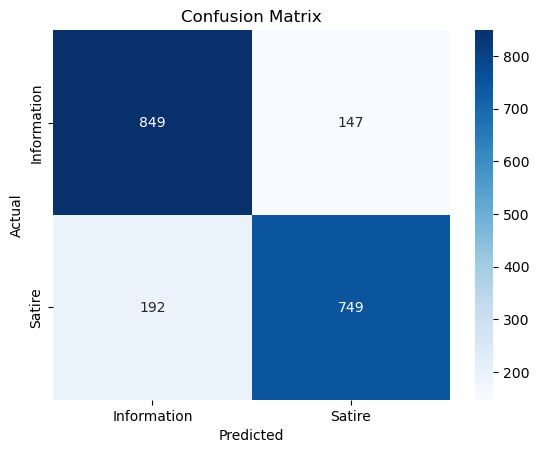

In [ ]:
X = df["cleaned_headline"]
y = df["is_satirical"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

---

## 🔠 TF-IDF Vectorization
TF-IDF vectorization is fast, efficient, and widely used for short text sequences like this.
Transform text into numerical vectors with stopword removal and bigrams (to capture frequent expressions as well)

In [ ]:
vectorizer = TfidfVectorizer(
    lowercase=True, stop_words=FRENCH_STOP_WORDS, ngram_range=(1, 2)
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

---

## 🧠 Logistic Regression Model
Simple, fast, robust model that provides a good baseline for binary classification

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Model evaluation
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Information", "Satire"],
    yticklabels=["Information", "Satire"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

---

## 🧠 Feature Importance
Identify which tokens were most influential in classification.

In [ ]:
# Creation of a DataFrame associating
# - tokens (= features) retrieved from the vectorizer, to the
# - coefficients learned by the model (one per feature)
features_df = pd.DataFrame(
    {"feature": vectorizer.get_feature_names_out(), "coefficient": model.coef_[0]}
)

# Ranking tokens/features by importance of impact
top_positive = features_df.sort_values(by="coefficient", ascending=False).head(20)
top_negative = features_df.sort_values(by="coefficient").head(20)

print("🟥 Words most associated to *informative* headlines:")
print(top_negative)

print("\n🟩 Words most associated to *satirical* headlines:")
print(top_positive)

🟥 Words most associated to *informative* headlines:
             feature  coefficient
43138         procès    -3.544866
54972          trump    -3.240438
25455         guerre    -2.849705
55852           unis    -2.727413
32076           lyon    -2.374799
17217         droits    -2.308635
21144           face    -2.187950
17987        défense    -2.156154
30049        justice    -2.141368
16935         douane    -2.096928
17222  droits douane    -2.059613
31297          ligue    -1.996677
13450         contre    -1.944749
36771        nations    -1.903458
3526      américains    -1.887261
3434       américain    -1.856751
59861     états unis    -1.818634
4495           appel    -1.817206
595             2025    -1.797063
52762         séisme    -1.788281

🟩 Words most associated to *satirical* headlines:
               feature  coefficient
53556             test     3.782640
13877      coronavirus     3.538560
32282           macron     2.524284
21309            faire     2.238016
335

---

## 📊 Visualize Discriminative Features
Barplot comparing the most impactful words for each class.

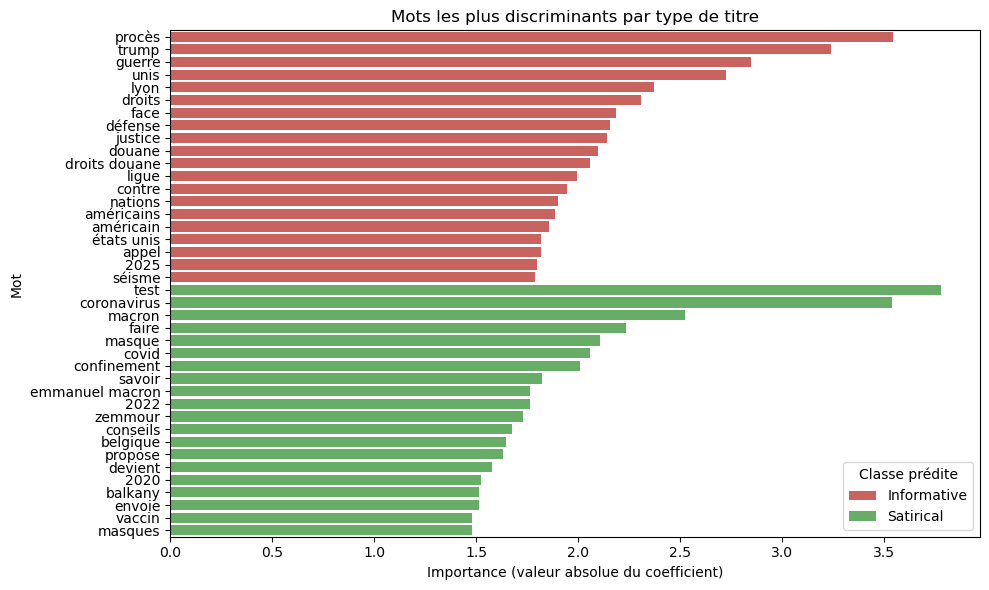

In [ ]:
# Combines the top 10 words of each class into a single DataFrame
top_features_df = pd.concat(
    [
        top_negative.assign(class_label="Informative"),
        top_positive.assign(class_label="Satirical"),
    ]
)

# Negative coefficients are taken absolutely to facilitate visual comparison.
top_features_df["abs_coefficient"] = top_features_df["coefficient"].abs()

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features_df,
    y="feature",
    x="abs_coefficient",
    hue="class_label",
    palette=["#d9534f", "#5cb85c"],
)
plt.title("Most discriminating tokens per headline type")
plt.xlabel("Importance (coefficient absolute value)")
plt.ylabel("Token")
plt.legend(title="Predicted class")
plt.tight_layout()
plt.show()

---

## 💾 Save Model Pipeline

In [ ]:
# Creation of a complete pipeline: vectorization + classification
model_pipeline = Pipeline(
    [
        ("tfidf", vectorizer),
        ("classifier", model),
    ]
)

os.makedirs("../models", exist_ok=True)
# Saving the entire pipeline for future use
joblib.dump(model_pipeline, "../models/logistic_pipeline.joblib")

['../models/logistic_pipeline.joblib']